### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util import numpy_support as vtk_np
import matplotlib.pyplot as plt
import gc

import sys

#add path
sys.path.insert(0, '../../src/simulator')     # import path/to/synthpy

import beam as beam_initialiser
import diagnostics as diag
import domain as d
import propagator as p
import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)
importlib.reload(utils)

<module 'utils' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/examples/notebooks/../../src/simulator/utils.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [42]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 128

#x = np.linspace(-extent_x, extent_x, n_cells)
#y = np.linspace(-extent_y, extent_y, n_cells)
#z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

print("Garbage collection count:", gc.collect())

#domain = d.ScalarDomain(x = x, y = y, z = z, extent= probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

# clear we should do manual garbage collection of some variety in d.ScalarDomain function
print("Garbage collection count:", gc.collect())

Garbage collection count: 4172
Garbage collection count: 0


Load some domain distribution

In [43]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

#domain.ne = np.full((100, 100, 100), 1e24)
domain.test_exponential_cos()
#domain.test_slab(0.000001, 1e24)

Solve gradients, initialise beam, and solve

In [44]:
wl = 1064e-9 #define laser wavelength

# initialise beam
Np = 1    # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

initial_rays = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction, wl, beam_type)

tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False)

# solve ray trace
tracer.calc_dndr()
final_rays = tracer.solve(parallelise = True, jitted = True)
#final_rays, final_rays_to_Jonesvector = tracer.Beam.rf, tracer.Beam.Jf
print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")


Available devices: [CpuDevice(id=0)]

jax compilation of solver took: 0.0013141632080078125
Running device: cpu, with: 16 cores.


                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                     CPU 0                                      
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                

File: ls
Type: space
Showing nodes accounting for 453781.75kB, 100% of 453923.22kB total
Dropped 77 nodes (cum <= 2269.62kB)
      flat  flat%   sum%        cum   cum%
248980.89kB 54.85% 54.85% 257173.50kB 56.66%  apply_primitive
204800.79kB 45.12%   100% 204809.31kB 45.12%  __call__
    0.08kB 1.7e-05%   100% 196608.10kB 43.31%  deferring_binary_op
         0     0%   100% 453923.22kB   100%  [ls]
         0     0%   100%    49152kB 10.83%  _array_copy
         0     0%   100%    49152kB 10.83%  _copy_impl
         0     0%   100% 24576.79kB  5.41%  _pjit_call_impl_python
         0     0%   100% 453923.22kB   100%  _pseudo_sync_runner
         0     0%   100% 24576.84kB  5.41%  _python_pjit_helper
         0     0%   100% 453923.22kB   100%  _run
         0     0%   100% 453923.22kB   100%  _run_cell
         0     0%   100% 453923.22kB   100%  _run_code
         0     0%   100% 453923.22kB   100%  _run_module_as_main
         0     0%   100% 453923.22kB   100%  _run_once
         0 

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:

<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>

rf size expected: (1, 1)
rf after clearing nan's: (1, 1)
Garbage collection count: 19


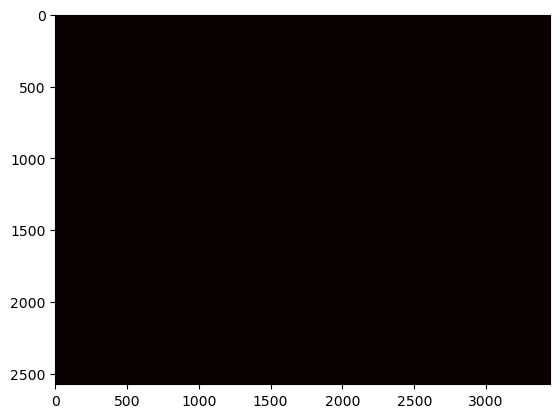

In [45]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(tracer.Beam)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>

rf size expected: (1, 1)
rf after clearing nan's: (1, 1)
Garbage collection count: 3148


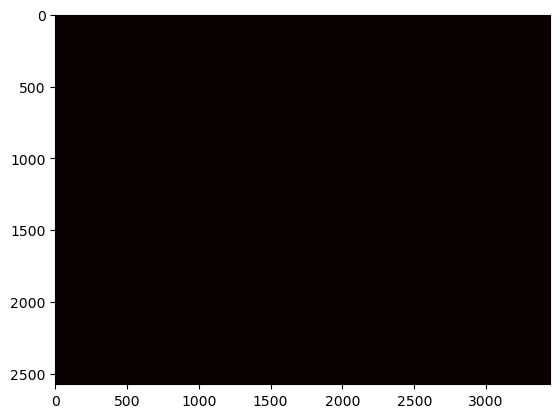

In [46]:
shadowgrapher = diag.Shadowgraphy(tracer.Beam)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>

rf size expected: (1, 1)
rf after clearing nan's: (1, 1)
Garbage collection count: 3154


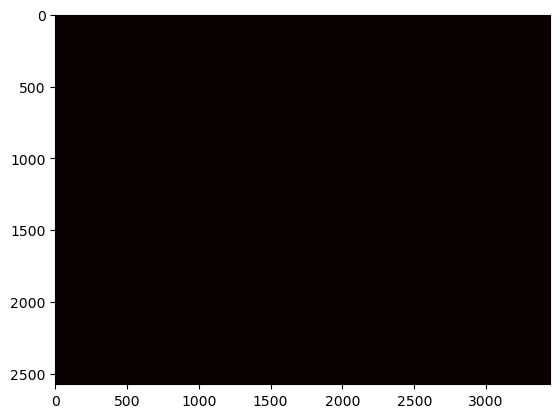

In [47]:
schlierener = diag.Schlieren(tracer.Beam)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [48]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam



# solve ray trace
tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = True)

tracer.calc_dndr()

tracer.Beam.rf, tracer.Beam.Jf = tracer.solve(parallelise = False, jitted = False, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis

interferometrer = diag.Interferometry(tracer.Beam)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(tracer.Beam)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H



x-y size expected: (1, 1)
Final rays: [[-6.16833673e-04]
 [ 3.58447910e-03]
 [ 1.82842712e-02]
 [-2.85959248e+06]
 [ 8.46457431e+06]
 [ 2.99792458e+08]
 [ 1.00000000e+00]
 [-4.87671032e+01]
 [ 0.00000000e+00]]
x-y after clearing nan's: (1, 1)
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>


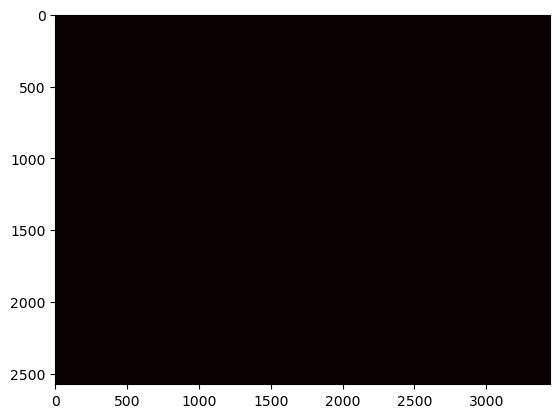

In [49]:
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')